In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import json
import numpy.random as npr
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# mpl.rcParams["figure.dpi"] = 300
# plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern Roman"})

# Recap: Qiskit IBM Runtime Estimator primitive workflow


The Estimator primitive lets you calculate expectation values of quantum operators by specifying a list of circuits and observables. For a more detailed introductoin visit [this other tutorial](0-estimator.ipynb).

## 1. Specify problem

Let us first specify some example problem, i.e., a list of circuits and a list of observables that we want to measure on these circuits.

### Define circuits

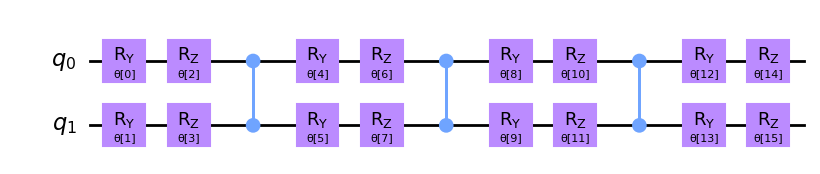

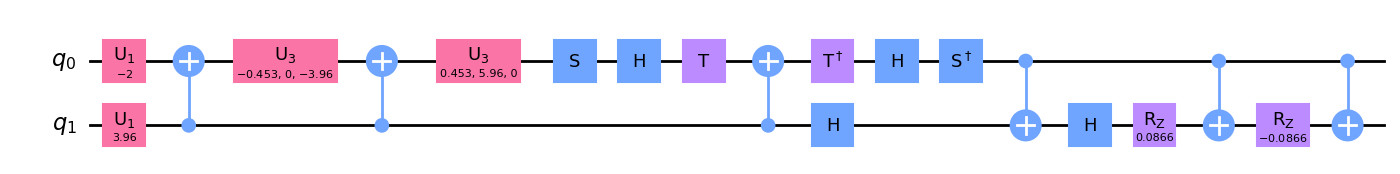

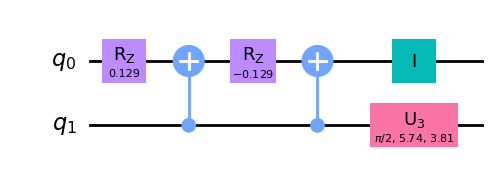

In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.random import random_circuit

circuits = [
    TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz").decompose(reps=1),
    random_circuit(2, 4, seed=1).decompose(reps=1),
    random_circuit(2, 2, seed=0).decompose(reps=1)
]

_ = [display(c.draw("mpl")) for c in circuits]

### Define observables

In [3]:
from qiskit.quantum_info import SparsePauliOp

observables = [
    SparsePauliOp("ZZ"),
    SparsePauliOp("XX"),
    SparsePauliOp("YY"),
]

## 2. Instantiate Estimator

In [4]:
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi as Backend


estimator = BackendEstimator(backend=Backend())

# measure expectation values of observable-0 and 1 on circuit-0 (with specified parameters)
job_0 = estimator.run(
    circuits=[circuits[0]] * len(observables),
    observables=observables,
    parameter_values=[[*npr.random(16)]] * len(observables),
    shots=2048,
)

# measure expectation values of observable-0 and 1 on circuit-1
job_1 = estimator.run(
    circuits=[circuits[1]] * len(observables),
    observables=observables,
    shots=2048,
)

result_1 = job_1.result()
result_1

EstimatorResult(values=array([ 0.90136719, -0.02734375, -0.00488281]), metadata=[{'variance': 0.18753719329833984, 'shots': 2048}, {'variance': 0.9992523193359375, 'shots': 2048}, {'variance': 0.9999761581420898, 'shots': 2048}])

In [5]:
result_1  # print again for comparison on consecutive runs

EstimatorResult(values=array([ 0.90136719, -0.02734375, -0.00488281]), metadata=[{'variance': 0.18753719329833984, 'shots': 2048}, {'variance': 0.9992523193359375, 'shots': 2048}, {'variance': 0.9999761581420898, 'shots': 2048}])

# Zero noise extrapolation Estimator

The `ZNEEstimator` extends `BackendEstimator` and performs zero noise extrapolation on top of it, taking the same arguments and being called through the same syntax. For a more detailed discussion visit [this other tutorial](1-zne.ipynb).

In [6]:
from zne import zne
ZNEEstimator = zne(BackendEstimator)  # Any implementation of BaseEstimator can be passed

## Specify ZNE strategy
If you simply replace `BackendEstimator` --> `ZNEEstimator`, the conventional `BackendEstimator` primitive will be called (without performing ZNE).

To perform zero noise extrapolation (ZNE), all we need is to provide a `ZNEStrategy` object when instantiating the Estimator. The `ZNEStrategy` takes in the following arguments:

- **noise_factors**: A list of noise amplification factors.
- **noise_amplifier**: The noise amplification strategy (e.g. whether to use global or local gate folding).
- **extrapolator**: The extrapolation strategy (e.g. whether to use a linear or polynomial extrapolator).

In [7]:
from zne import ZNEStrategy
# from zne.noise_amplification import GlobalFoldingAmplifier, LocalFoldingAmplifier
# from zne.extrapolation import LinearExtrapolator, PolynomialExtrapolator

zne_strategy = ZNEStrategy(
    noise_factors=(1, 3, 5),
    # noise_amplifier = LocalFoldingAmplifier()
    # extrapolator = LinearExtrapolator()
)

In [8]:
estimator = ZNEEstimator(
    backend=Backend(), 
    zne_strategy=zne_strategy  # !!!
)

# measure expectation values of observable-0 and 1 on circuit-0 (with specified parameters)
job_0 = estimator.run(
    circuits=[circuits[0]] * len(observables),
    observables=observables,
    parameter_values=[[*npr.random(16)]] * len(observables),
    shots=2048,
)

# measure expectation values of observable-0 and 1 on circuit-1
job_1 = estimator.run(
    circuits=[circuits[1]] * len(observables),
    observables=observables,
    shots=2048,
)

result_1 = job_1.result()
result_1

EstimatorResult(values=array([ 0.93033854, -0.00252279,  0.0078125 ]), metadata=({'zne': {'noise_amplification': {'noise_amplifier': <CxAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>, 'noise_factors': (1, 3, 5), 'values': (0.9013671875, 0.841796875, 0.7841796875), 'variance': (0.18753719329833984, 0.2913780212402344, 0.38506221771240234), 'shots': (2048, 2048, 2048)}, 'extrapolation': {'extrapolator': LinearExtrapolator}}}, {'zne': {'noise_amplification': {'noise_amplifier': <CxAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>, 'noise_factors': (1, 3, 5), 'values': (-0.005859375, 0.02734375, 0.0126953125), 'variance': (0.9999656677246094, 0.9992523193359375, 0.9998388290405273), 'shots': (2048, 2048, 2048)}, 'extrapolation': {'extrapolator': LinearExtrapolator}}}, {'zne': {'noise_amplification': {'noise_amplifier': <CxAmplifier:{'noise_factor_relative_tolerance': 0

## ZNE metadata
Beautifying the results:

In [9]:
from zne.utils.serialization import EstimatorResultEncoder

print(EstimatorResultEncoder.dumps(result_1, indent=2))

{
  "values": [
    0.9303385416666667,
    -0.0025227864583333304,
    0.007812500000000002
  ],
  "metadata": [
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "<CxAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
          "noise_factors": [
            1,
            3,
            5
          ],
          "values": [
            0.9013671875,
            0.841796875,
            0.7841796875
          ],
          "variance": [
            0.18753719329833984,
            0.2913780212402344,
            0.38506221771240234
          ],
          "shots": [
            2048,
            2048,
            2048
          ]
        },
        "extrapolation": {
          "extrapolator": "LinearExtrapolator"
        }
      }
    },
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "<CxAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 

## Noise Amplifiers

Currently only digital noise amplification is implemented:

* `GlobalFoldingAmplifier`
* `LocalFoldingAmplifier`
    * `CxAmplifier`

In [10]:
from zne import NOISE_AMPLIFIER_LIBRARY
NOISE_AMPLIFIER_LIBRARY.keys()

dict_keys(['CxAmplifier', 'LocalFoldingAmplifier', 'GlobalFoldingAmplifier'])

In [11]:
from zne.noise_amplification import GlobalFoldingAmplifier, LocalFoldingAmplifier

Each `NoiseAmplifier` has a method called `amplify_circuit_noise` which takes the original circuit and a noise factor as input and returns the corresponding noise amplified circuit.

In [12]:
mpl.rcParams["figure.dpi"] = 300
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern Roman"})

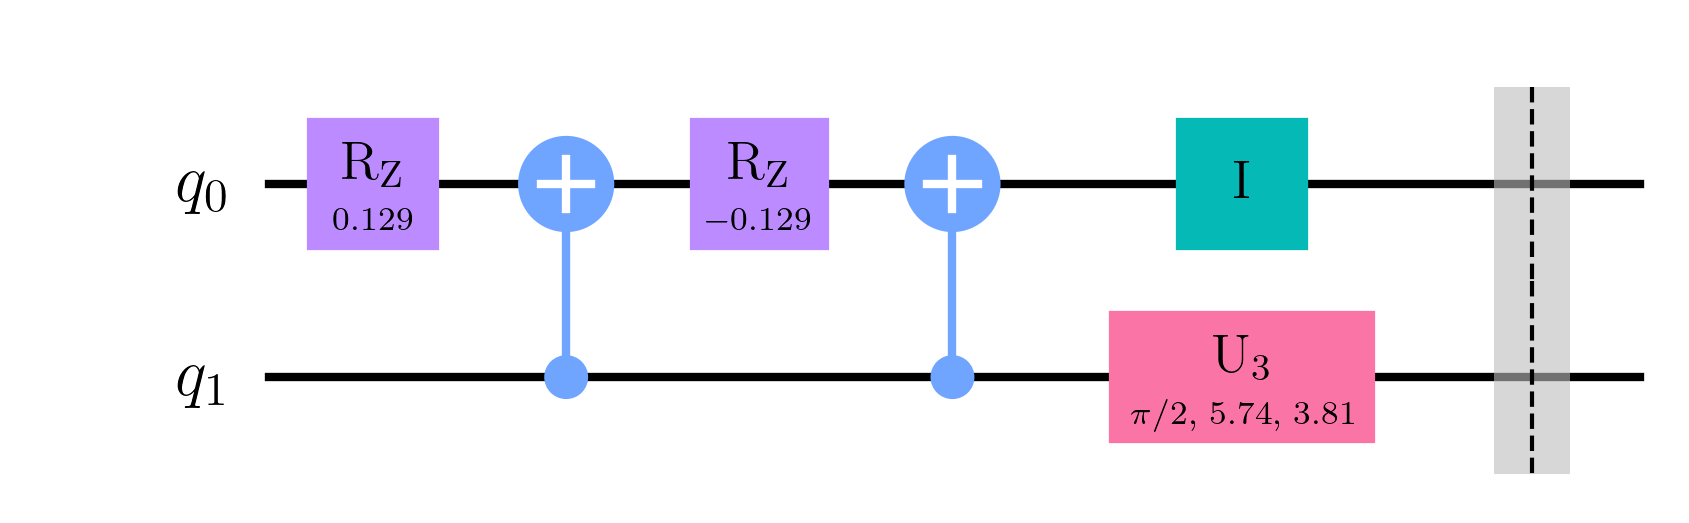

In [13]:
noise_amplifier = GlobalFoldingAmplifier()

noisy_circuit = noise_amplifier.amplify_circuit_noise(circuit=circuits[2], noise_factor=1)

display(noisy_circuit.draw("mpl", plot_barriers=True))

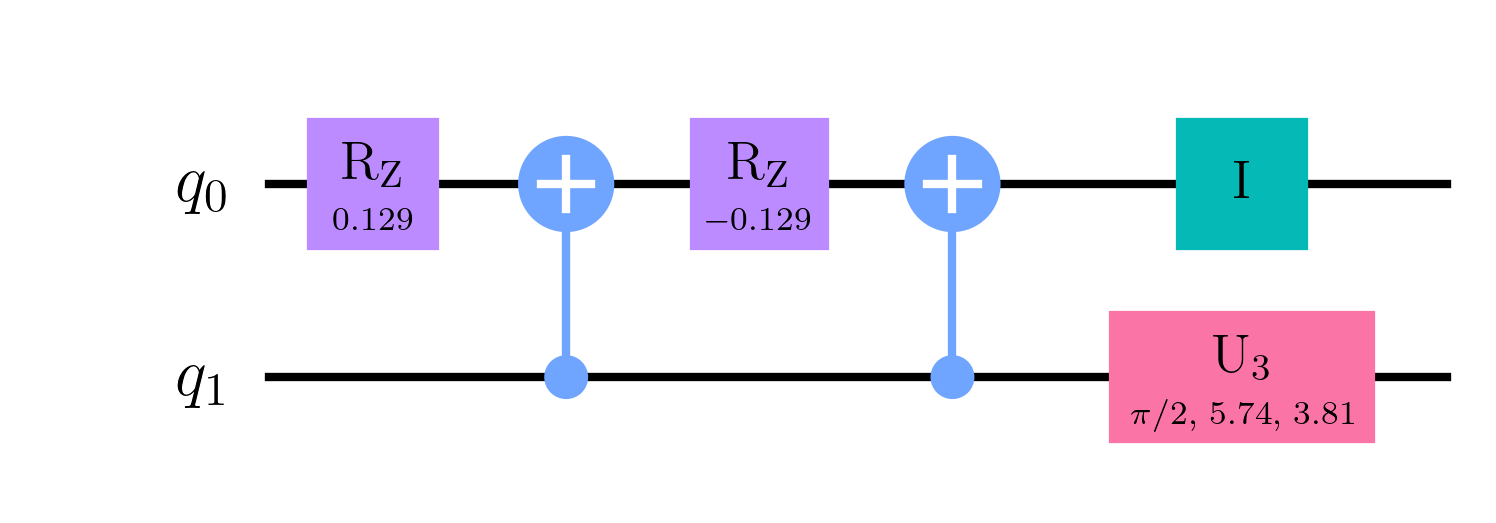

In [14]:
noise_amplifier = LocalFoldingAmplifier()

noisy_circuit = noise_amplifier.amplify_circuit_noise(circuit=circuits[2], noise_factor=1)

display(noisy_circuit.draw("mpl", plot_barriers=False))

The FoldingAmplifiers take in the following optional arguments:

- **gates_to_fold**: A list of `int`/`str` specifying which gates to fold.
- **sub_folding_option**: `from_first`, `from_last`, `random`: Specifies how to fold the gates if the noise factor is not an odd integer.
- **random_seed**: Used when performing random sub-folding.

### 1. Sub-foldings

Whenever the noise factor is __not an odd integer__, we have to additionally fold sub-parts of the circuit to account for these intermediate noise factors.

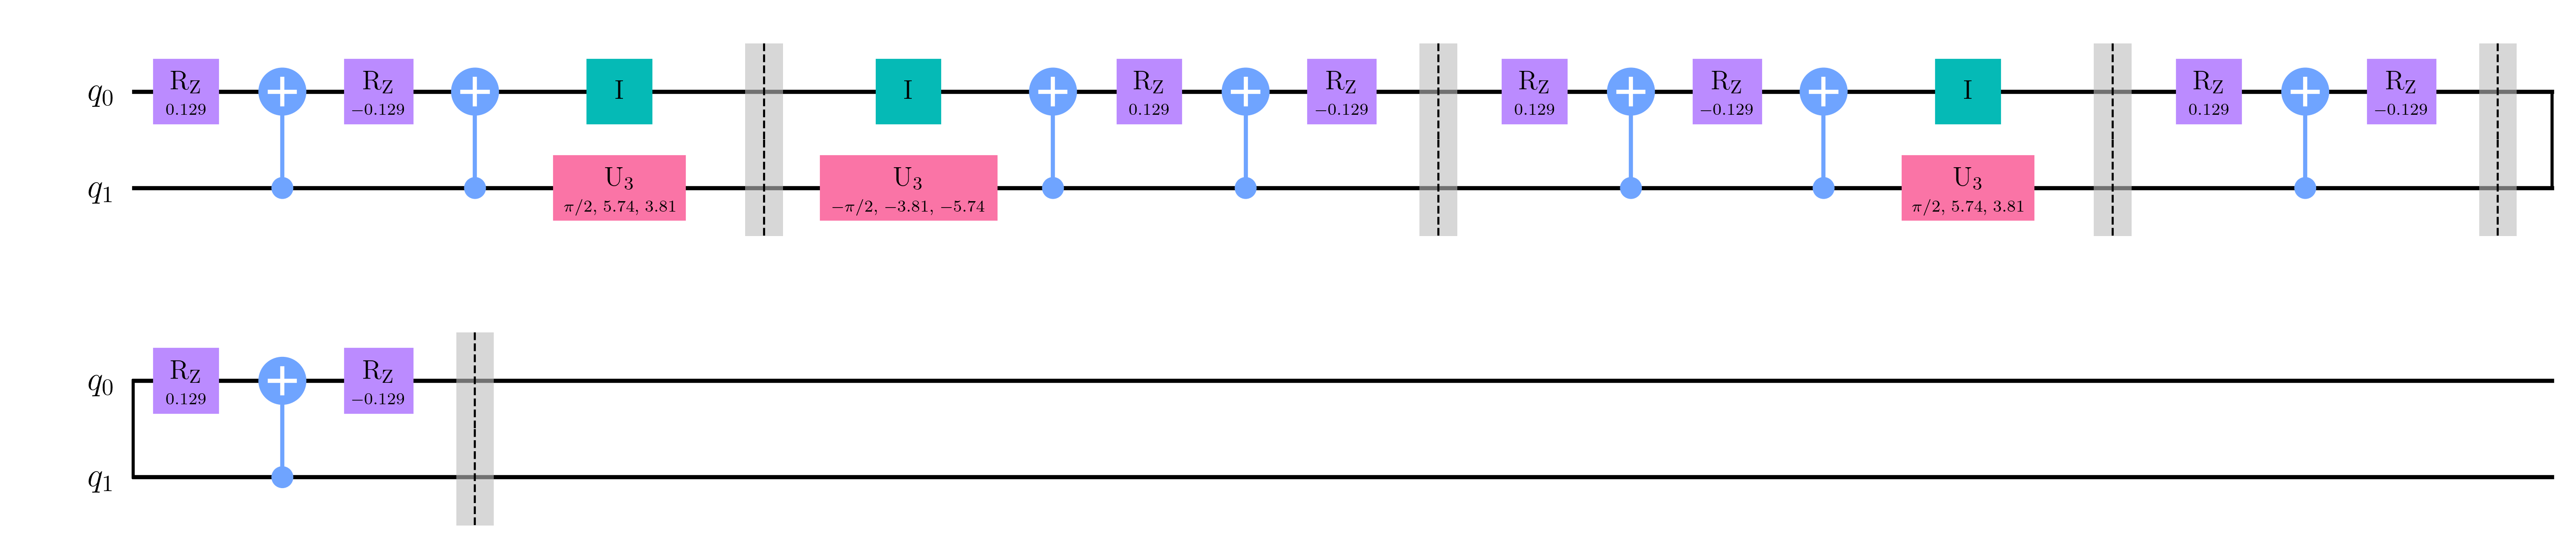

In [15]:
noise_amplifier = GlobalFoldingAmplifier(
    sub_folding_option = "from_first",
    # random_seed = 123,
)

noisy_circuit = noise_amplifier.amplify_circuit_noise(circuit=circuits[2], noise_factor=4)

display(noisy_circuit.draw("mpl", plot_barriers=True))

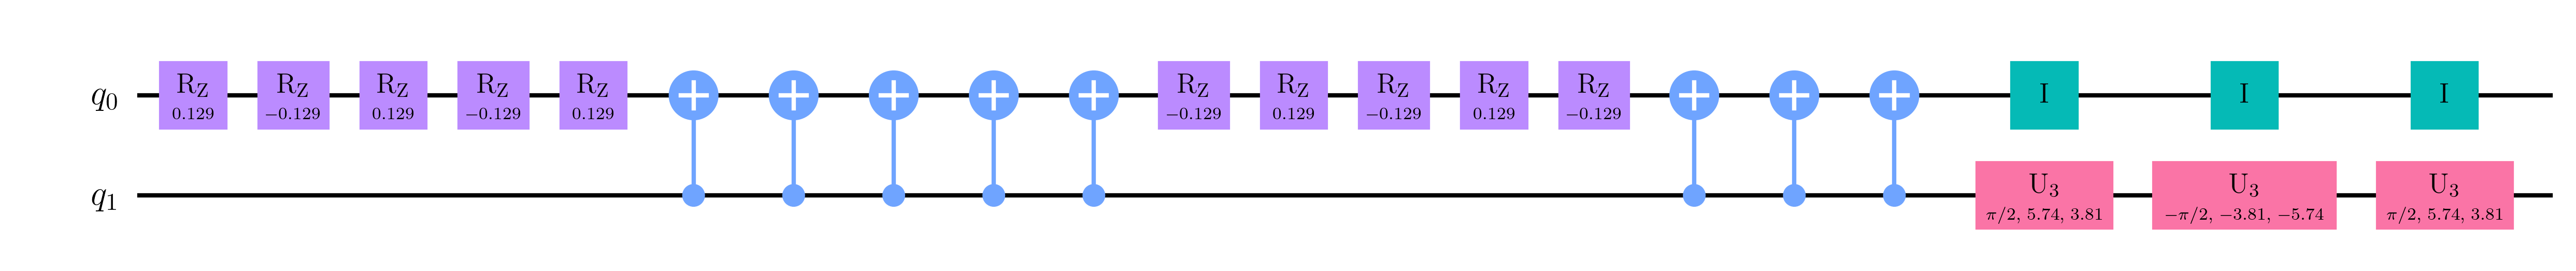

In [16]:
noise_amplifier = LocalFoldingAmplifier(
    sub_folding_option = "from_first",
    # random_seed = 123,
)

noisy_circuit = noise_amplifier.amplify_circuit_noise(circuit=circuits[2], noise_factor=4)

display(noisy_circuit.draw("mpl", plot_barriers=False))

### 2. Folding only a specified set of gates

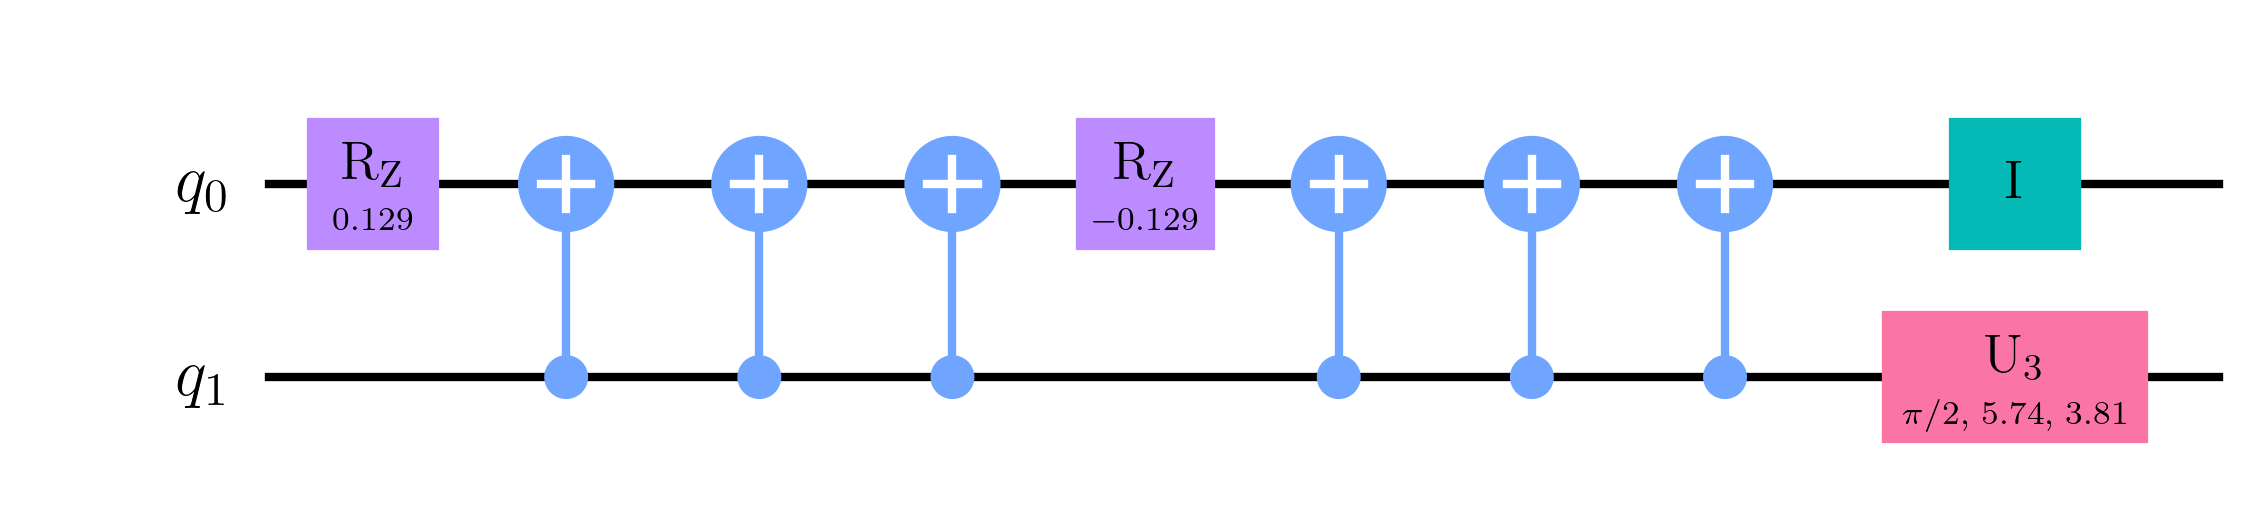

In [17]:
noise_amplifier = LocalFoldingAmplifier(
    gates_to_fold = 2,  # Two-qubit gates
    # gates_to_fold = "cx",
    # gates_to_fold = ["cx", "rz"],
    # gates_to_fold = [2, "rz"],
)

noisy_circuit = noise_amplifier.amplify_circuit_noise(circuit=circuits[2], noise_factor=3)

display(noisy_circuit.draw("mpl", plot_barriers=False))

__Note__: You can define custom instructions (e.g. `TwoLocal`, `RealAmplitudes`) and specify to fold those as well.

### Transpilation

Currently noise amplification is performed __before__ transpilation. This will change soon!

## Custom ZNE strategies

The current implementation of `ZneEstimator` allows us build custom noise amplification, and extrapolation techniques:

In [18]:
from zne.extrapolation import Extrapolator
from zne.noise_amplification import CircuitNoiseAmplifier


############################  NOISE AMPLIFIER  ############################
class CustomAmplifier(CircuitNoiseAmplifier):
    def amplify_circuit_noise(self, circuit, noise_factor):
        return circuit.copy()  # Dummy, nonperforming


############################  EXTRAPOLATOR  ############################
class CustomExtrapolator(Extrapolator):
    @property
    def min_points(self):
        return 2
    
    def _fit_regression_model(self, data):
        prediction = 1.0
        variance = 0.0
        model = lambda target: (prediction, variance)
        return model, {"metadata": None}  # Dummy, nonperforming

Which we then provide during instantiation through a `ZNEStrategy` object:

In [19]:
zne_strategy = ZNEStrategy(
    noise_amplifier=CustomAmplifier(),
    noise_factors=(1, 3),
    extrapolator=CustomExtrapolator(),
)

estimator = ZNEEstimator(backend=Backend(), zne_strategy=zne_strategy)
    
job = estimator.run(
    circuits=circuits[1],
    observables=observables[1],
)
    
result = job.result()
print(EstimatorResultEncoder.dumps(result, indent=2))

{
  "values": [
    1.0
  ],
  "metadata": [
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "CustomAmplifier",
          "noise_factors": [
            1,
            3
          ],
          "values": [
            0.0078125,
            0.02734375
          ],
          "variance": [
            0.99993896484375,
            0.9992523193359375
          ],
          "shots": [
            1024,
            1024
          ]
        },
        "extrapolation": {
          "extrapolator": "CustomExtrapolator",
          "variance": 0.0,
          "metadata": null
        }
      }
    }
  ]
}


## Full example

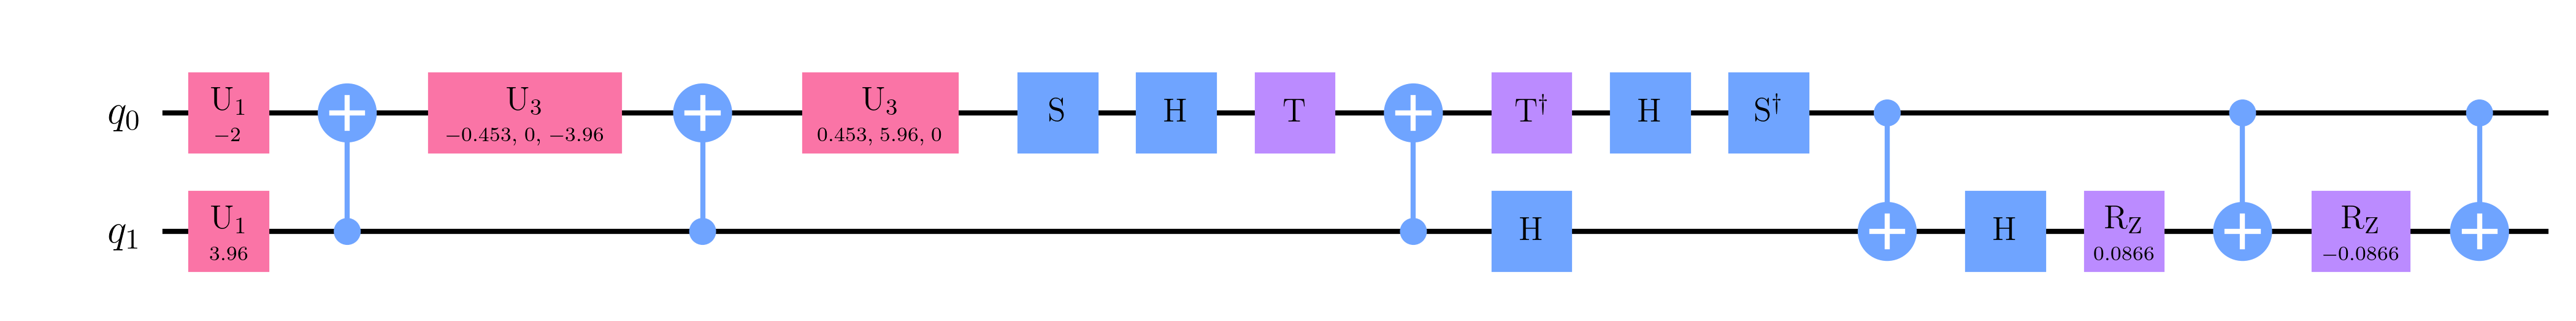

In [20]:
cir = circuits[1]
display(cir.draw("mpl"))

In [21]:
obs = observables[0]
print(obs)

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])


In [22]:
noise_factors = range(1,9)
list(noise_factors)

[1, 2, 3, 4, 5, 6, 7, 8]

In [23]:
from zne.extrapolation import PolynomialExtrapolator

## ZNE STRATEGY
noise_amplifier = LocalFoldingAmplifier(
    gates_to_fold=2,
    sub_folding_option='from_first',
)

extrapolator = PolynomialExtrapolator(
    degree=2,
)

zne_strategy = ZNEStrategy(
    noise_factors=noise_factors,
    noise_amplifier=noise_amplifier,
    extrapolator=extrapolator,
)

In [24]:
## CALCULATION
estimator = ZNEEstimator(backend=Backend(), zne_strategy=zne_strategy)
    
job = estimator.run(
    circuits=cir,
    observables=obs,
)
    
result = job.result()

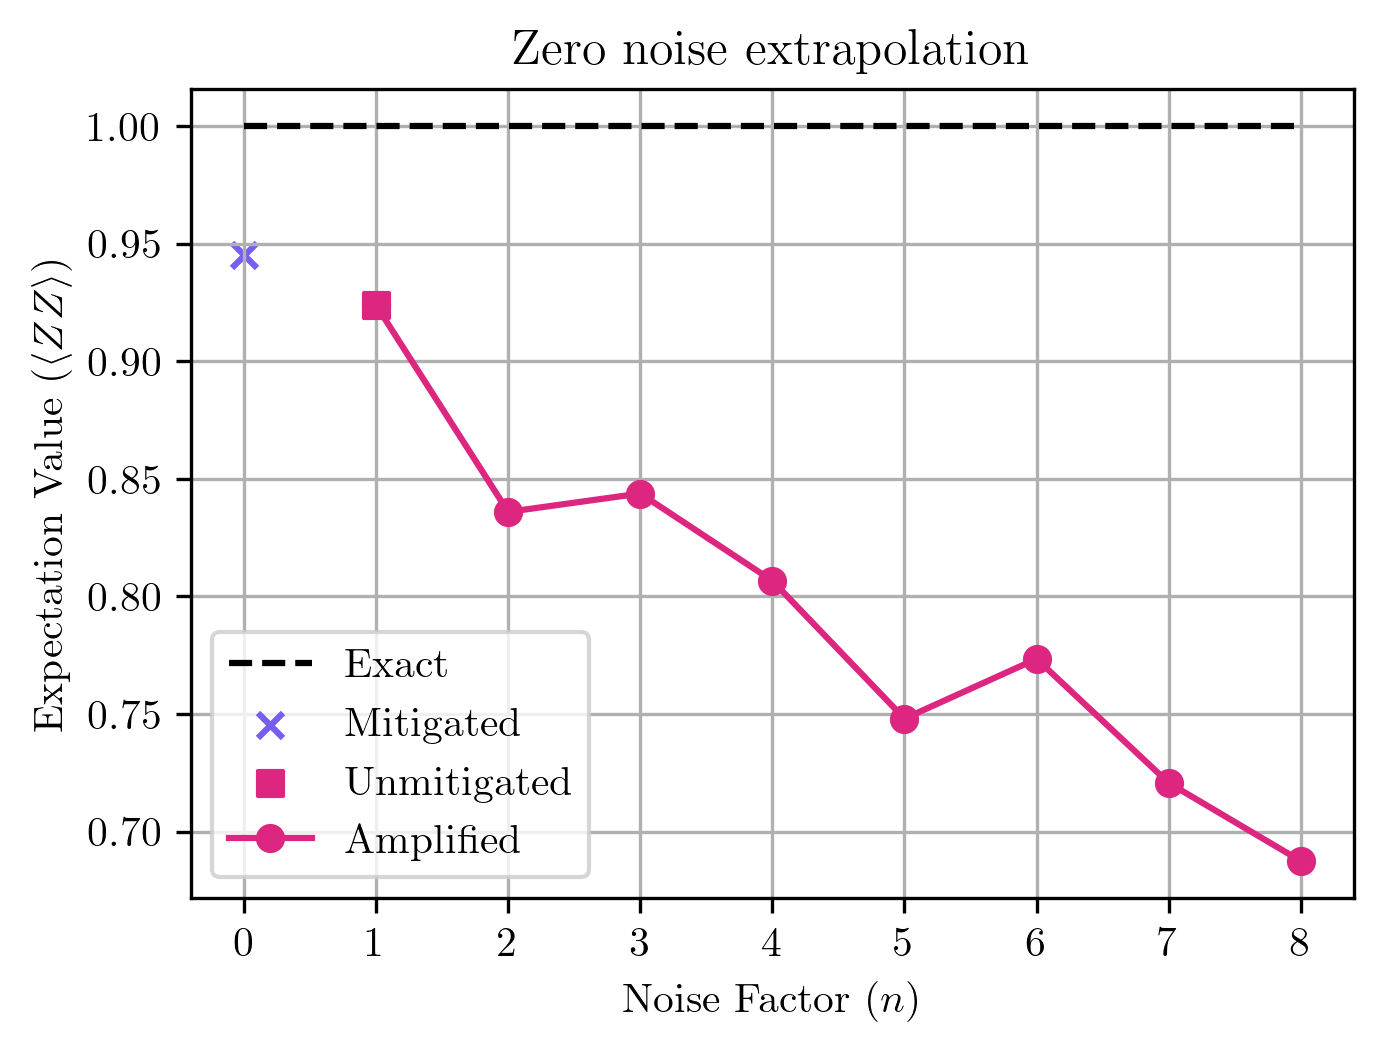

In [25]:
############################  DATA  ############################
exact = Estimator().run(cir, obs).result().values[0]
mitigated = result.values[0]
noise_factors = result.metadata[0]["zne"]["noise_amplification"]["noise_factors"]
noisy_values = result.metadata[0]["zne"]["noise_amplification"]["values"]

############################  PLOT  ############################
plt.rcParams["figure.figsize"] = (5,3.5)
plt.grid(which='major',axis='both')

plt.plot([0, noise_factors[-1]], [exact, exact], "--", label=f"Exact", color="#000000")
plt.scatter(0, mitigated, label=f"Mitigated", marker="x", color="#785ef0")
if noise_factors[0] == 1:
    plt.scatter(
        noise_factors[0], noisy_values[0], 
        label=f"Unmitigated", marker="s", color="#dc267f",
    )
plt.plot(
    noise_factors, noisy_values, 
    label=f"Amplified", marker="o", color="#dc267f",
)

plt.title("Zero noise extrapolation")
plt.xlabel("Noise Factor ($n$)")
plt.ylabel(f"Expectation Value ($\langle ZZ \\rangle$)")
plt.legend()

plt.show()

In [26]:
import qiskit.tools.jupyter  # pylint: disable=unused-import,wrong-import-order

%qiskit_version_table
%qiskit_copyright